### Import Packages

In [1]:
import pandas as pd
import seaborn
import math
import sklearn
import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%matplotlib inline

### Import Data and Prep for Modeling
#### Relabel Dependent variable to Binary

In [2]:
model_data_v2 = pd.read_csv('data/all_data_Model4.csv')
model_data_v3 = model_data_v2.replace({
    'AU': 'other',
    'CA': 'other',
    'DE': 'other',
    'ES': 'other',
    'FR': 'other',
    'GB': 'other',
    'IT': 'other',
    'NL': 'other',
    'PT': 'other',
    'NDF': 'other'
})

In [3]:
df_dummified_y = model_data_v3['country_destination']
model_data_x_dummy_prep=model_data_v3.drop(["country_destination","Unnamed: 0"], axis=1)

### Dummify Features

In [4]:
df_dummified_x = pd.get_dummies(
    model_data_x_dummy_prep,
    columns=['Age_Over40', 'Age_31-39',
       'Age_Under31', 'Age_unknown', 'Month_account_created','gender', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'
],
    drop_first=True)

### Update Syntax from string to  binary so model is classified as bivariate. 

In [5]:
df_dummified_y_2=df_dummified_y.replace({'other':0,'US':1})

### Visualize new variables

In [6]:
list_col=[i for i in df_dummified_y_2.values]
list_col2=list(set(list_col))
list_col2

[0, 1]

### Split into Train and Test

In [7]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_dummified_x, df_dummified_y_2, test_size=0.3, stratify=df_dummified_y,)
X_trained_notscaled=X_train.copy()
len(y_train)

51670

### Smote to fix class imbalance

In [8]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 


In [9]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

Xy_smote=X_smote,X_smote

In [10]:
len(y_smote)

75208

### Scale the Train and Dataset for LR

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_smote = scaler.fit_transform(X_smote)
X_test = scaler.transform(X_test)
len(X_smote)

75208

### Tuple For Easy Reference

In [12]:
skip_size = 10 # skip every n examples

In [13]:
Xy_train=X_train,y_train
Xy_train_skip=X_train[::skip_size],y_train[::skip_size]

X_train_skip=X_train[::skip_size]
y_train_skip=y_train[::skip_size]

Xy_test=X_test,y_test
Xy_test_skip=X_test[::skip_size],y_test[::skip_size]

X_smote_skip=X_smote[::skip_size]
y_smote_skip=y_smote[::skip_size]
Xy_smote_skip=Xy_smote[::skip_size]

len(y_train)

51670

### Functions Defined that will be used for analysis (Methods)

In [14]:
def classify(model,X_test,X_train,y_train):
    """predicts y first, classify, """
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test,y_pred))
    print(model.score(*Xy_test))
    print(metrics.confusion_matrix(y_test, y_pred))
    

def plot_roc_curve(model, x_test, y_test):

    y_score=model.predict_proba(x_test)[:,1]

    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,8))
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr,color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve (AUC = ' + str(roc_auc)+ ')')

def analyze_coef(df_with_cols,model,num_points):
    feat = df_with_cols.columns
    coef = model.coef_.flatten()
    sort_i = np.argsort(-np.abs(coef))


    n_plot = num_points
    ind = np.arange(n_plot)
    plt.figure(figsize=(40,10))
    plt.xticks(rotation=90)
    plt.scatter(ind, coef[sort_i][:n_plot])
    plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
    plt.title("Top coefficients for CV-optimized lasso model")
    plt.ylabel("coefficient");

    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

### Establish Baseline
#### 27% For TruePositives

In [15]:
y_test.value_counts()/len(y_test)

0    0.727749
1    0.272251
Name: country_destination, dtype: float64

### Model Using Sklearns - Random Forest Classifier 

In [16]:
rfc = RandomForestClassifier(max_depth=6.5,min_samples_split=48,verbose=0,max_features=60,class_weight='balanced')
rfc.fit(X_smote,y_smote)
rfc.score(X_test,y_test)

0.73912847143824789

In [17]:
classify(rfc,X_test,X_smote,y_smote)

             precision    recall  f1-score   support

          0       0.84      0.79      0.81     16116
          1       0.52      0.61      0.56      6029

avg / total       0.76      0.74      0.75     22145

0.739128471438
[[12663  3453]
 [ 2324  3705]]


### Visualize the ROC Curve

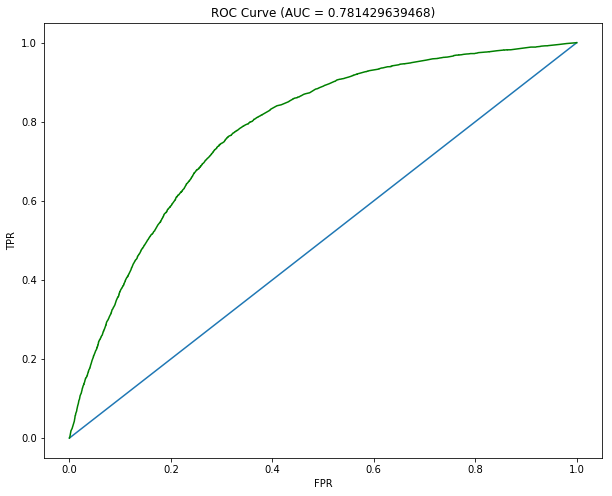

In [18]:
plot_roc_curve(rfc,X_test,y_test)

## Test Additional Models using the pipeline

LR: 0.676872 (0.113460)


/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.348624 (0.125478)
KNN: 0.443463 (0.048331)


/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RFC: 0.544492 (0.038163)


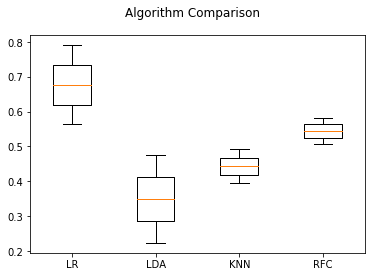

In [19]:
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(penalty='l2', class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('SVM', SVC()))
models.append(('RFC',
               RandomForestClassifier(
                   max_depth=6.5,
                   min_samples_split=48,
     
                   max_features=60,
                   oob_score=True)))
#
# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model,
        X_smote[::skip_size],y_smote[::skip_size],

        cv=kfold,
        scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###  Confusion Matrix of the best model: Logistic Regression

In [20]:
logic_r_model=LogisticRegression(penalty='l2', class_weight='balanced')
logic_r_model.fit(X_smote,y_smote)
logic_r_model.score(X_test,y_test)
classify(logic_r_model,X_test,X_smote,y_smote)

             precision    recall  f1-score   support

          0       0.88      0.70      0.78     16116
          1       0.48      0.73      0.58      6029

avg / total       0.77      0.71      0.72     22145

0.707112214947
[[11235  4881]
 [ 1605  4424]]


###  Coefs of the best model: Logistic Regression

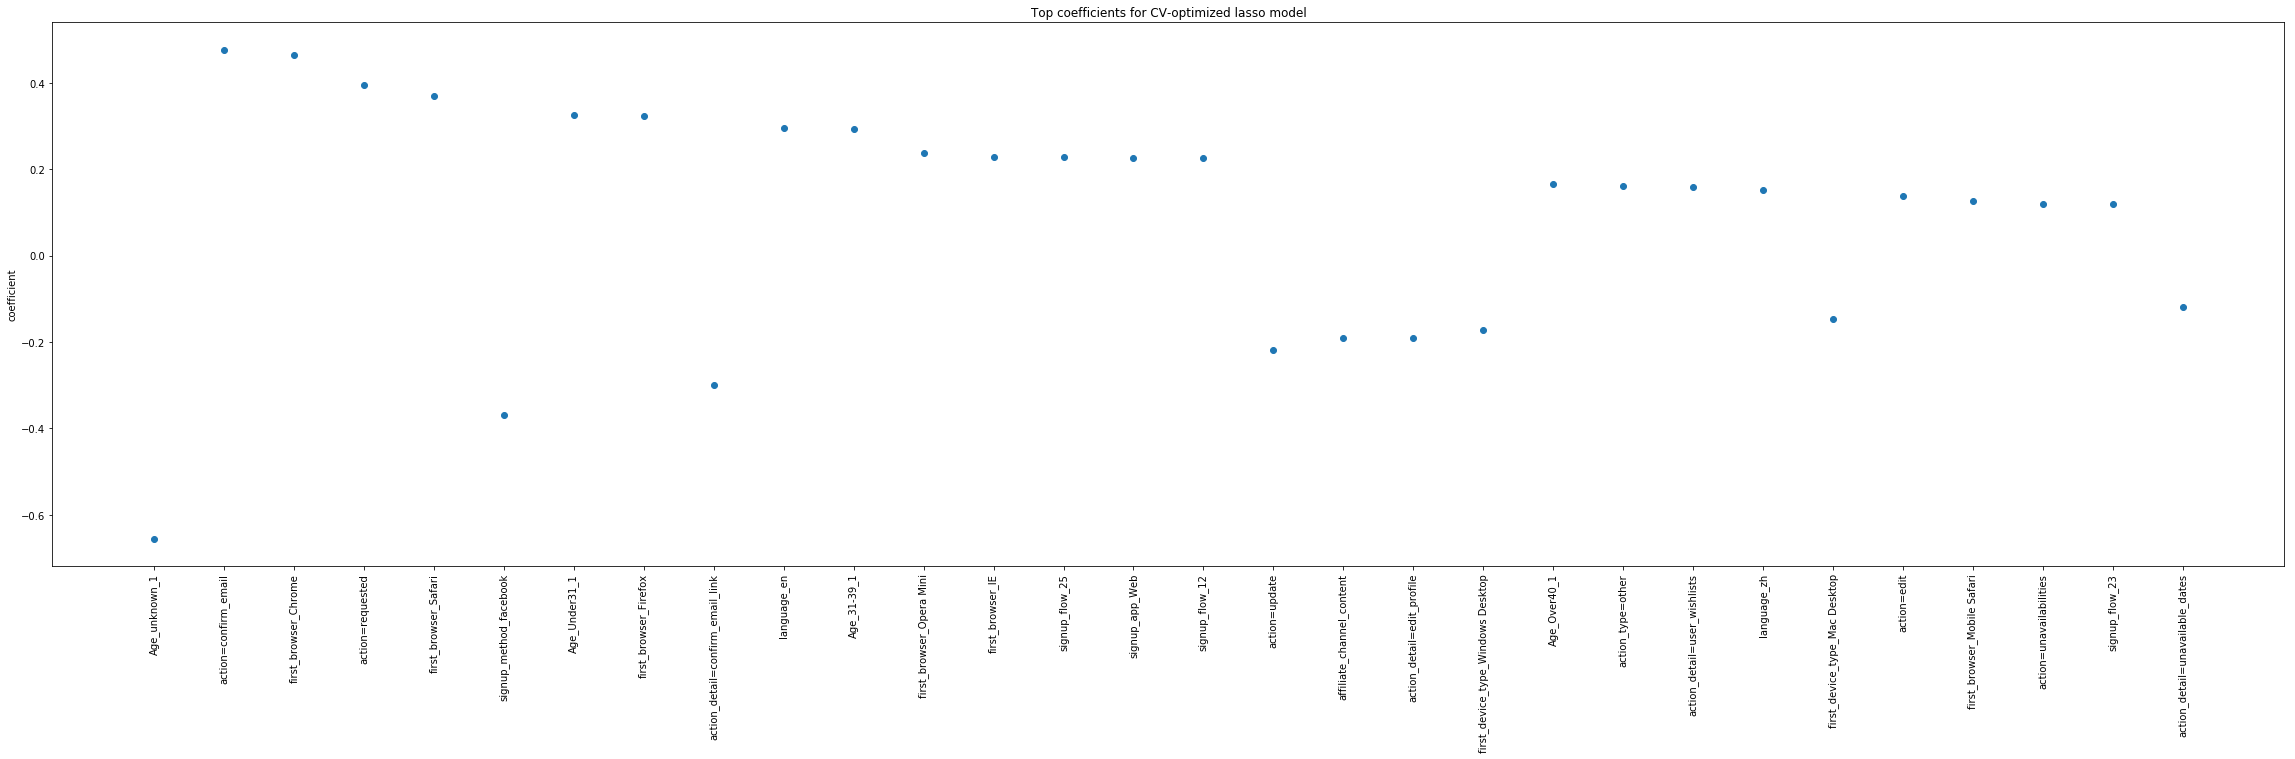

In [21]:
analyze_coef(X_trained_notscaled,logic_r_model,30)

### Perform Grid Search to optimize the model

In [22]:
#Declare Grid
param_grid2 = {
    "solver": ['saga'],
    "multi_class": ['ovr', 'multinomial']
}


### Attach Grid to the model

In [23]:
rbf_grid2 = model_selection.GridSearchCV(logic_r_model, param_grid2, cv=3, scoring='f1')

rbf_grid2.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

### Perform Grid Search

In [24]:
rbf_grid2.fit(X_smote_skip,y_smote_skip)

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: C

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['saga'], 'multi_class': ['ovr', 'multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [25]:
rbf_grid2.score(X_smote_skip,y_smote_skip)

0.73794170750580346

### Extract the best model

In [26]:
new_model=rbf_grid2.best_estimator_
rbf_grid2.best_estimator_

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [27]:
new_model.fit(X_smote_skip,y_smote_skip)
new_model.score(X_test,y_test)

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.69907428313389031

### Classify the best model

In [28]:
classify(new_model,X_test,X_smote_skip,y_smote_skip)

             precision    recall  f1-score   support

          0       0.88      0.68      0.77     16116
          1       0.47      0.74      0.57      6029

avg / total       0.77      0.70      0.71     22145

0.699074283134
[[10993  5123]
 [ 1541  4488]]


### Establish the best threshold for the class:
#### Step 1: Plot Precision Recall Curve

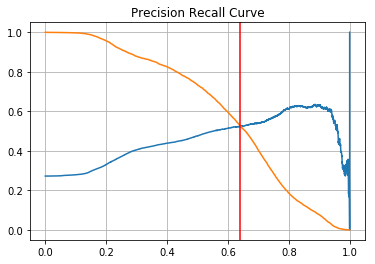

In [29]:
### Plot the precision recall curve to determine the threshold.
from  sklearn.metrics import precision_recall_curve

y_score_pr_curve=logic_r_model.predict_proba(X_test)[:,1]
p,r,t=precision_recall_curve(y_test,y_score_pr_curve)

# adding last threshold of '1' to threshold list
t=np.vstack([t.reshape([-1,1]),1])

plt.plot(t,p)
plt.plot(t,r);
plt.grid()
plt.axvline(x=.640589566 , color='red');
plt.title('Precision Recall Curve');

## Step 2: Plot a custom cost function  
### Helps optimize the curve
* True Positive = gain 1 Dollar
* False Positive = loss 50 cents
* False Negative = loss 50 cents

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


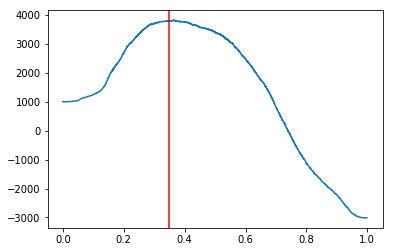

In [30]:
n_pos = np.sum(y_test)
true_pos = r*n_pos
false_neg = n_pos - true_pos
false_pos = true_pos/p-true_pos
smeet_cost = 1.5*true_pos -.5*false_neg -.5*false_pos
plt.plot(t, smeet_cost)
plt.axvline(x=.35 , color='red');

### Plot Cost Function and Precision Recall Curve Side by Side

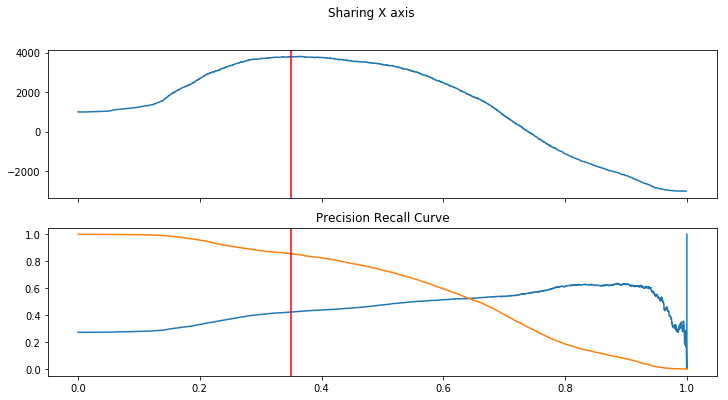

In [31]:
x=[i for i in range(20)]
y=[i*5 for i in range(20)]
x2=[i for i in range(20)]
y2=[(i)*.5 for i in range(20)]

f, axarr = plt.subplots(2,figsize=(12,6),sharex=True)

f.suptitle('Sharing X axis')
axarr[0].plot(t, smeet_cost)
axarr[1].plot(t,p)
axarr[1].plot(t,r)
axarr[1].set_title('Cost Function')
axarr[1].set_title('Precision Recall Curve')
axarr[1].axvline(x=.35 , color='red');
axarr[0].axvline(x=.35 , color='red');

### Plot Confusion Matrix and Analyze results for the new threshold.
* This is the final Model. 
* Threshold of .35
* Precision of .42
* Recall of .86


In [32]:
y_predict_proba=logic_r_model.predict_proba(X_test)[:,1]

In [33]:
y_pred_threshold=y_predict_proba > .35
y_pred_threshold

array([False,  True, False, ...,  True, False, False], dtype=bool)

In [34]:
t=metrics.confusion_matrix(y_test,y_pred_threshold) 


Confusion matrix, without normalization
[[9084 7032]
 [ 874 5155]]


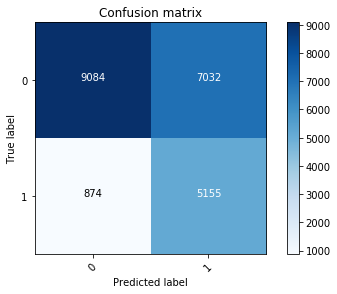

In [35]:
plot_confusion_matrix(t,[0,1])

In [36]:
print(metrics.classification_report(y_test,y_pred_threshold))

             precision    recall  f1-score   support

          0       0.91      0.56      0.70     16116
          1       0.42      0.86      0.57      6029

avg / total       0.78      0.64      0.66     22145

